In [6]:
import sys
from time import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.mllib.evaluation import RegressionMetrics


In [3]:
def extract_label(fields):
    label = (fields[-1])
    return float(label)-1

def extract_features(record,featureEnd):
    featureSeason= [convert_float(field) for field in record[2]]
    numericalFeatures = [convert_float(field) for field in record[4:featureEnd-2]]
    return np.concatenate((featureSeason, numericalFeatures))

def convert_float(x):
    return (0 if x=='?' else float(x))


In [4]:
def PrepareData(sc):
    global Path
    if sc.master[0:5]=='local':
       Path = "file:/home/hadoop/pythonwork/data/Bike-Sharing" 
    else:
       Path = "hdfs:/user/hduser/Bike-Sharing" 
    
    print 'data loading..'
    rawDataWithHeader = sc.textFile(Path+'/hour.csv')
    header = rawDataWithHeader.first()
    rawData = rawDataWithHeader.filter(lambda x: x != header)
    lines = rawData.map(lambda x:x.split(","))
    print str(lines.count())
    #-----------construct the training data RDD[LabeledPoint]
    labelpointRDD = lines.map(lambda r:LabeledPoint(
                    extract_label(r),
                    extract_features(r, len(r) - 1)))
    print labelpointRDD.first()
    #randomly split the data as training data, validation data, and testing data
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print('trainData size:'+str(trainData.count())+ 
          ', validData size:'+str(validationData.count())+
          ', testData size:'+str(testData.count()))
    return (trainData, validationData, testData)

In [5]:
(trainData, validationData, testData) = PrepareData(sc)
trainData.persist()
validationData.persist()
testData.persist()

data loading..
17379
(15.0,[1.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0])
trainData size:13845, validData size:1781, testData size:1753


PythonRDD[10] at RDD at PythonRDD.scala:48

In [7]:
def evaluateModel(model, validationData):    
    score = model.predict(validationData.map(lambda p: p.features)).map(lambda x: float(x)) #modify by myself
    scoreAndLabels = score.zip(validationData.map(lambda p: p.label))
    metrics = RegressionMetrics(scoreAndLabels)
    RMSE = metrics.rootMeanSquaredError
    return(RMSE)  

def trainEvaluateModel(trainData, validationData, impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainRegressor(trainData, categoricalFeaturesInfo={}, impurity=impurityParm,
                                        maxDepth=maxDepthParm, maxBins=maxBinsParm)
    RMSE = evaluateModel(model, validationData)
    duration = time() - startTime
    print "train evaluation(params):" +\
    "impurity="+str(impurityParm)+\
    ", maxDepth="+str(maxDepthParm)+\
    ", maxBins="+str(maxBinsParm)+"\n"+\
    "==>required time:"+str(duration)+\
    " ,RMSE=%.2f"%(RMSE)
    
    return (RMSE,duration,impurityParm,maxDepthParm,maxBinsParm,model)

In [10]:

model = DecisionTree.trainRegressor(trainData, categoricalFeaturesInfo={}, impurity="variance",
                                     maxDepth=5, maxBins=5)
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels = score.zip(validationData.map(lambda p: p.label))
print score.take(5)
print validationData.map(lambda p: p.label).take(5)
print scoreAndLabels.take(5)

metrics = RegressionMetrics(scoreAndLabels)
RMSE = metrics.rootMeanSquaredError
print RMSE

[115.7764705882353, 115.7764705882353, 115.7764705882353, 5.16614420062696, 104.50248756218906]
[92.0, 36.0, 7.0, 4.0, 60.0]
[(115.7764705882353, 92.0), (115.7764705882353, 36.0), (115.7764705882353, 7.0), (5.16614420062696, 4.0), (104.50248756218906, 60.0)]
129.033918776


In [11]:
sc.master

u'local[*]'

In [13]:
def showchart(df, evalparm, barData, lineData, yMin, yMax):
    ax = df[barData].plot(kind='bar', title=evalparm, figsize=(10,6), legend=True, fontsize=12)
    ax.set_xlabel(evalparm, fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData, fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData].values, linestyle='-', marker='o', linewidth=2.0, color='r')
    plt.show()
    
def evalParameter(trainData, validationData, evalparm, impurityList, maxDepthList, maxBinsList):
    metrics = [trainEvaluateModel(trainData, validationData, impurity, maxDepth, maxBins)
               for impurity in impurityList
               for maxDepth in maxDepthList
               for maxBins in maxBinsList]
    
    if evalparm == "impurity":
       IndexList=impurityList[:] 
    elif evalparm == "maxDepth":
       IndexList=maxDepthList[:]  
    elif evalparm == "maxBins":
       IndexList=maxBinsList[:]
    df = pd.DataFrame(metrics, index=IndexList,
                  columns=["RMSE", "duration", "impurity", "maxDepth", "maxBins", "model"])
    showchart(df, evalparm, 'RMSE', 'duration', 0, 200)

train evaluation(params):impurity=variance, maxDepth=3, maxBins=10
==>required time:0.989336967468 ,RMSE=130.24
train evaluation(params):impurity=variance, maxDepth=5, maxBins=10
==>required time:1.00702118874 ,RMSE=115.24
train evaluation(params):impurity=variance, maxDepth=10, maxBins=10
==>required time:1.24399900436 ,RMSE=85.89
train evaluation(params):impurity=variance, maxDepth=15, maxBins=10
==>required time:2.31322789192 ,RMSE=99.36
train evaluation(params):impurity=variance, maxDepth=20, maxBins=10
==>required time:3.87333607674 ,RMSE=105.03
train evaluation(params):impurity=variance, maxDepth=25, maxBins=10
==>required time:5.45203495026 ,RMSE=107.14


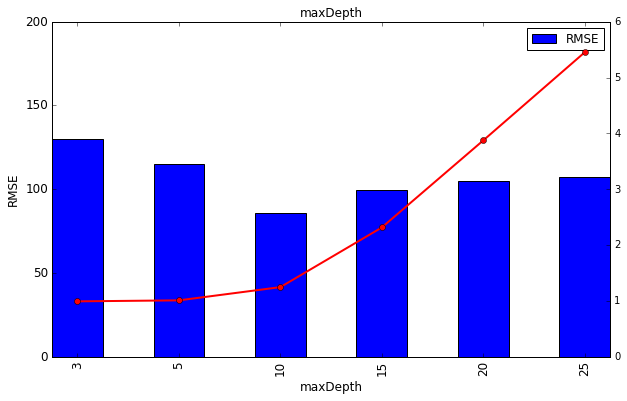

In [14]:
evalParameter(trainData, validationData, 
              "maxDepth", impurityList=["variance"], 
              maxDepthList=[3, 5, 10, 15, 20, 25], maxBinsList=[10])

train evaluation(params):impurity=variance, maxDepth=10, maxBins=3
==>required time:1.19719386101 ,RMSE=128.10
train evaluation(params):impurity=variance, maxDepth=10, maxBins=5
==>required time:1.07634592056 ,RMSE=116.85
train evaluation(params):impurity=variance, maxDepth=10, maxBins=10
==>required time:1.11586117744 ,RMSE=85.89
train evaluation(params):impurity=variance, maxDepth=10, maxBins=50
==>required time:1.14275813103 ,RMSE=77.84
train evaluation(params):impurity=variance, maxDepth=10, maxBins=100
==>required time:1.19079399109 ,RMSE=78.10
train evaluation(params):impurity=variance, maxDepth=10, maxBins=200
==>required time:1.22147798538 ,RMSE=78.10


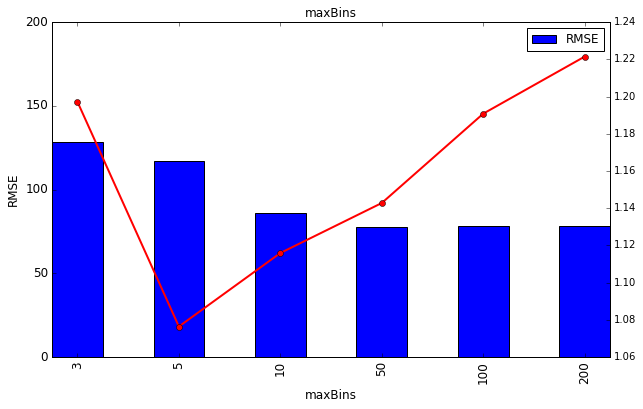

In [15]:
evalParameter(trainData, validationData, 
              "maxBins", impurityList=["variance"], 
              maxDepthList=[10], maxBinsList=[3, 5, 10, 50, 100, 200])

In [18]:
BestModel = DecisionTree.trainRegressor(trainData, categoricalFeaturesInfo={}, impurity="variance",
                                     maxDepth=10, maxBins=50)